Qui troverai l'ultimo passo "dell'avventura" iniziata con [questo articolo](https://massimilianomoraca.me/blog/gis/pm10-nord-italia/) in cui riporto l'andamento del PM10 nel nord Italia nell'ultimo decennio. Il come ho proceduto all'analisi è riportato in [quest'altro articolo](https://massimilianomoraca.me/blog/pygis-blog/analisi-dellandamento-del-pm10-nel-nord-italia/).

Lo scopo dell'articolo che stai per leggere è visualizzare su mappa le aree di analisi, cosa che fino ad ora non avevo mostrato.

Tutto l'iter è stato bello lungo ed è per questo che l'ho dovuto suddividere in ben tre differenti articoli.

# Prima di iniziare

## Librerie

Come per tutti gli [articoli di PyGIS-Blog](https://massimilianomoraca.me/blog/pygis-blog/) inizio con l'elenco delle librerie usate. Una menzione speciale è per la funzione `xarray.open_mfdataset` perchè mi ha consentito di velocizzare tantissimo la lettura di tutti i file `.nc` grazie al nativo supporto a `dask.delayed`. 

Devo approfondire Dask appena ho tempo e [Dask Delayed](https://docs.dask.org/en/stable/delayed.html) sembra un buon punto di partenza pratico su cui lavorare per il mio solito training on the job :)

In [1]:
from pathlib import Path
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import patheffects

## Fonti dati

Come già spiegato nei precedenti articoli di questa involontaria miniserie, i dati usati sono quelli distributi dal Copernicus Atmosphere Monitoring Service. In particolare ho usato dati con una copertura temporale che va dal 2013 a marzo 2024.

In [2]:
nc_data_path = Path("/home/max/Desktop/pianura_padana/processed/netcdf")

nc_files = list(nc_data_path.glob("*.nc"))

nc_files

[PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2021-forecasts.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2017-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2020-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2014-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2013-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2016-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2023-forecasts.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2019-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2015-reanalyses.nc'),
 PosixPath('/home/max/Desktop/

L'area geografica è sempre quella dei precedenti due articoli, la riporto comunque di seguito per completezza.

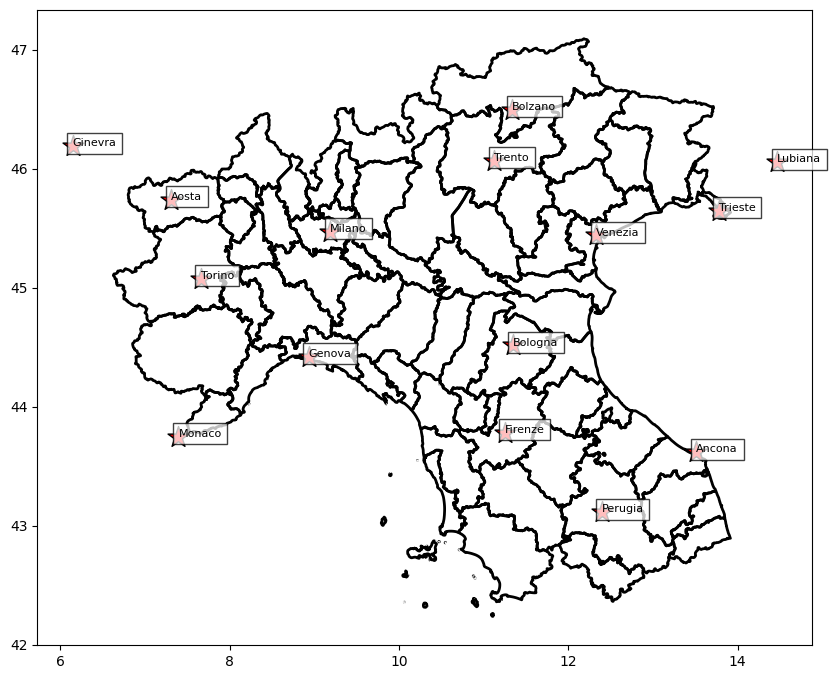

In [3]:
main_city_path = Path.cwd().joinpath('data', 'citta_significative.shp')
main_city = gpd.read_file(main_city_path)

target_zones_boundaries = Path.cwd().parent.parent.parent.parent.joinpath('sample_data').joinpath('ProvCM01012023_g').joinpath('ProvCM01012023_g_WGS84.shp')

target_zones = gpd.read_file(target_zones_boundaries)
target_zones = target_zones[target_zones['COD_REG'].isin(list(range(1, 12)))]
target_zones = target_zones.to_crs(4326).sort_values('DEN_UTS')


fig1, ax1 = plt.subplots(figsize=(10, 10))
target_zones.plot(
    ax=ax1,
    facecolor="none", 
    edgecolor="black",
    linewidth=2.0
)
for _index, _row in main_city.iterrows():
    coordinates = _row.geometry.xy
    ax1.scatter(
        *coordinates,
        s=250,
        marker="*",
        facecolor='red',
        edgecolor='black'
    )
    plt.text(
        x=coordinates[0][0],
        y=coordinates[1][0],
        s=_row.citta,
        fontdict=dict(color='black', size=8),
        bbox=dict(facecolor='white', alpha=0.75)
    )
plt.show()

## Contenuti
- [Analisi sul singolo file](#Analisi-sul-singolo-file)
- [Analisi su tutti i file](#Analisi-su-tutti-i-file)
- [Conclusione](#Conclusione)

# Analisi sul singolo file

## Lettura del `.nc`

Prima di iterare tutto il processo sull'intero arco temporale ho preferito effettuare delle verifiche su un solo anno, anche per prendere meglio confidenza con i dati.

In [4]:
single_dataset = xr.open_dataset(
    filename_or_obj='/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2013-reanalyses.nc',
    engine="netcdf4",
    decode_coords="all",
)

single_dataset

<xarray.Dataset> Size: 163MB
Dimensions:                  (time: 8760, lon: 91, lat: 51)
Coordinates:
  * time                     (time) datetime64[ns] 70kB 2013-01-01 ... 2013-1...
  * lon                      (lon) float64 728B 6.0 6.1 6.2 ... 14.8 14.9 15.0
  * lat                      (lat) float64 408B 42.0 42.1 42.2 ... 46.9 47.0
    spatial_ref              int64 8B ...
    level                    int64 8B ...
Data variables:
    particulate_matter_10um  (time, lat, lon) float32 163MB ...
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

Come si può vedere, il Dataset del 2013 è composto da 8760 ore (24h x 365d) per un peso di ben 163MB. Ricordo che la risoluzione spaziale di questi dati è circa 7.5km x 7.5km.

### Analisi sul singolo giorno

Di seguito punto all'estrazione e visualizzazione di una singola ora di un singolo giorno.

In [5]:
target_test_time = '2013-07-09T13:00:00'

target_hour_selection = single_dataset.sel(time=target_test_time).to_array().squeeze()
#target_hour_sel = target_hour_sel.rename({'lon': 'x', 'lat': 'y'})

target_hour_selection

<xarray.DataArray (lat: 51, lon: 91)> Size: 19kB
array([[32.88422  , 32.85841  , 32.44171  , ..., 13.436613 , 14.311139 ,
        15.214118 ],
       [33.01072  , 32.81864  , 32.40152  , ..., 15.240301 , 15.444803 ,
        15.649314 ],
       [33.0541   , 32.07483  , 31.37025  , ..., 15.6916895, 15.567043 ,
        15.631379 ],
       ...,
       [14.526992 , 14.565249 , 14.565497 , ..., 19.279963 , 19.53084  ,
        19.920486 ],
       [14.2113695, 14.210173 , 14.210417 , ..., 19.572437 , 20.62339  ,
        20.301117 ],
       [14.699474 , 14.72564  , 14.72589  , ..., 20.786325 , 21.017164 ,
        20.689896 ]], dtype=float32)
Coordinates:
    time         datetime64[ns] 8B 2013-07-09T13:00:00
  * lon          (lon) float64 728B 6.0 6.1 6.2 6.3 6.4 ... 14.7 14.8 14.9 15.0
  * lat          (lat) float64 408B 42.0 42.1 42.2 42.3 ... 46.7 46.8 46.9 47.0
    spatial_ref  int64 8B ...
    level        int64 8B ...
    variable     <U23 92B 'particulate_matter_10um'
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

In [6]:
s_min = target_hour_selection.min().values.round(2)
s_max = target_hour_selection.max().values.round(2)

print(f"Nell'ora presa in considerazione si nota che il PM10 minimo era pari a {s_min} µg/m3 ed il massimo era {s_max} µg/m3")

Nell'ora presa in considerazione si nota che il PM10 minimo era pari a 2.180000066757202 µg/m3 ed il massimo era 37.630001068115234 µg/m3


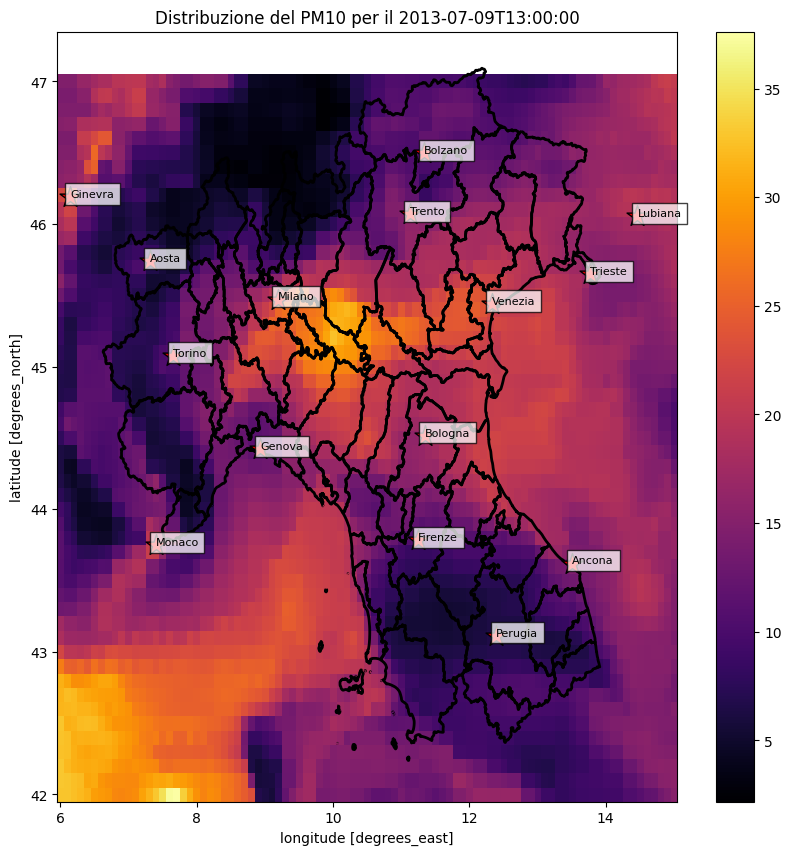

In [7]:
fig2, ax2 = plt.subplots(figsize=(10, 10))
target_zones.plot(
    ax=ax2,
    facecolor="none", 
    edgecolor="black",
    linewidth=2.0
)
target_hour_selection.plot.imshow(
    ax=ax2,
    cmap='inferno',
)
for _index, _row in main_city.iterrows():
    coordinates = _row.geometry.xy
    ax2.scatter(
        *coordinates,
        s=250,
        marker="*",
        facecolor='red',
        edgecolor='black'
    )
    plt.text(
        x=coordinates[0][0],
        y=coordinates[1][0],
        s=_row.citta,
        fontdict=dict(color='black', size=8),
        bbox=dict(facecolor='white', alpha=0.75)
    )
plt.title(f"Distribuzione del PM10 per il {target_test_time}")
plt.show()

## Conteggio degli sforamenti in un anno

Di seguito calcolo la media giornaliera per tutto l'anno in esame.

In [8]:
daily_data = single_dataset.resample(time='D').mean('time')  

daily_data

<xarray.Dataset> Size: 7MB
Dimensions:                  (lon: 91, lat: 51, time: 365)
Coordinates:
  * lon                      (lon) float64 728B 6.0 6.1 6.2 ... 14.8 14.9 15.0
  * lat                      (lat) float64 408B 42.0 42.1 42.2 ... 46.9 47.0
    spatial_ref              int64 8B 0
    level                    int64 8B 0
  * time                     (time) datetime64[ns] 3kB 2013-01-01 ... 2013-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) float32 7MB 14.59 14.76 ... 15.35
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

Quindi seleziono le sole celle che sforano il limite di 50 µg/m3 previsti dalla normativa.

In [9]:
daily_data_target = daily_data.copy()
daily_data_target['particulate_matter_10um'] = xr.where(daily_data['particulate_matter_10um'] >= 50, 1, 0)

daily_data_target

<xarray.Dataset> Size: 14MB
Dimensions:                  (lon: 91, lat: 51, time: 365)
Coordinates:
  * lon                      (lon) float64 728B 6.0 6.1 6.2 ... 14.8 14.9 15.0
  * lat                      (lat) float64 408B 42.0 42.1 42.2 ... 46.9 47.0
    spatial_ref              int64 8B 0
    level                    int64 8B 0
  * time                     (time) datetime64[ns] 3kB 2013-01-01 ... 2013-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) int64 14MB 0 0 0 0 0 ... 0 0 0 0 0
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

I pixel che sforano il limite li ho sostituiti con il valore 1 e gli altri con 0, in questo modo con il passaggio successivo ho potuto calcolare quante volte viene sforato il limite.

In [10]:
year_data = daily_data_target.resample(time='YE').sum('time')  

year_data

<xarray.Dataset> Size: 38kB
Dimensions:                  (lon: 91, lat: 51, time: 1)
Coordinates:
  * lon                      (lon) float64 728B 6.0 6.1 6.2 ... 14.8 14.9 15.0
  * lat                      (lat) float64 408B 42.0 42.1 42.2 ... 46.9 47.0
    spatial_ref              int64 8B 0
    level                    int64 8B 0
  * time                     (time) datetime64[ns] 8B 2013-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) int64 37kB 0 0 0 0 0 ... 0 0 0 0 0
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

In [11]:
y_min = year_data.min().to_array().values[0]
y_max = year_data.max().to_array().values[0]
law_limit = 35

print(f"Nell'anno preso in considerazione i valori di PM10 limite previsti dalla normativa sono stati sforati per un massimo di {y_max} volte. Il limite normativo è {law_limit}.")

Nell'anno preso in considerazione i valori di PM10 limite previsti dalla normativa sono stati sforati per un massimo di 58 volte. Il limite normativo è 35.


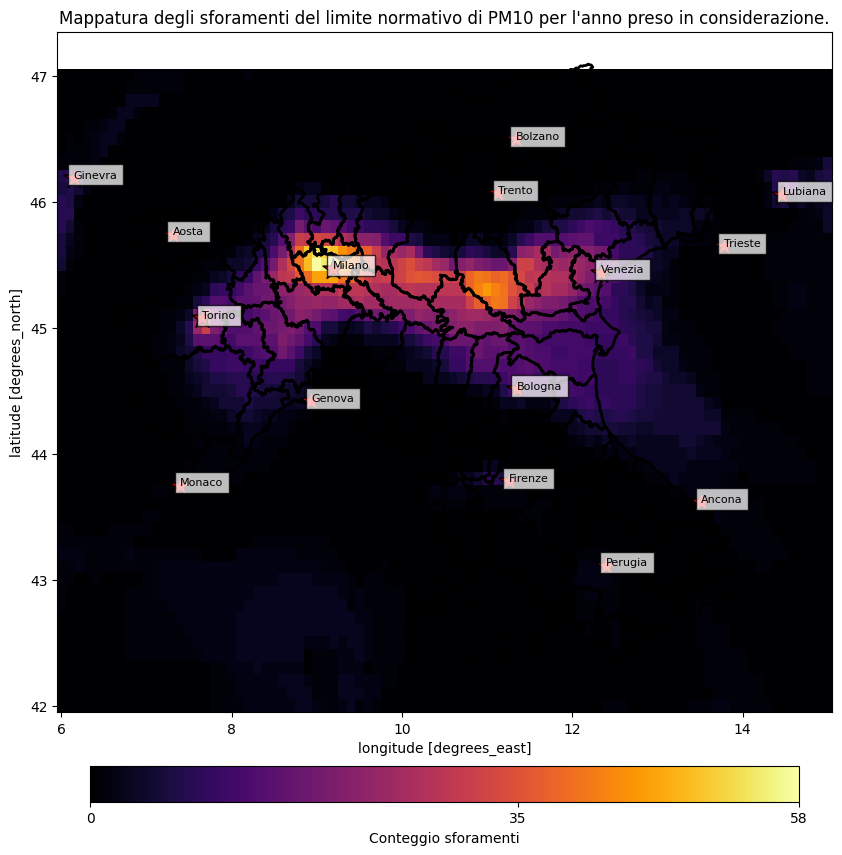

In [12]:
fig3, ax3 = plt.subplots(figsize=(10, 10))
target_zones.plot(
    ax=ax3,
    facecolor="none", 
    edgecolor="black",
    linewidth=2.0
)
year_data_img = year_data.to_array().squeeze().plot.imshow(
    ax=ax3,
    cmap='inferno',
    vmin=y_min,
    vmax=y_max,
    add_colorbar=False,
)
cbar_ax3 = plt.colorbar(
    year_data_img, 
    ax=ax3,
    orientation='horizontal',
    fraction=0.046, 
    pad=0.07,
)
cbar_ax3.set_label('Conteggio sforamenti')
cbar_ax3.set_ticks([y_min, law_limit, y_max])
cbar_ax3.set_ticklabels([str(y_min), str(law_limit), str(y_max)])
for _index, _row in main_city.iterrows():
    coordinates = _row.geometry.xy
    ax3.scatter(
        *coordinates,
        s=250,
        marker="*",
        facecolor='red',
        edgecolor='black'
    )
    plt.text(
        x=coordinates[0][0],
        y=coordinates[1][0],
        s=_row.citta,
        fontdict=dict(color='black', size=8),
        bbox=dict(facecolor='white', alpha=0.75)
    )
plt.title("Mappatura degli sforamenti del limite normativo di PM10 per l'anno preso in considerazione.")
plt.show()

Ora voglio visualizzare solo le aree che hanno effettivamente sforato il limite normativo di 35 sforamenti annui.

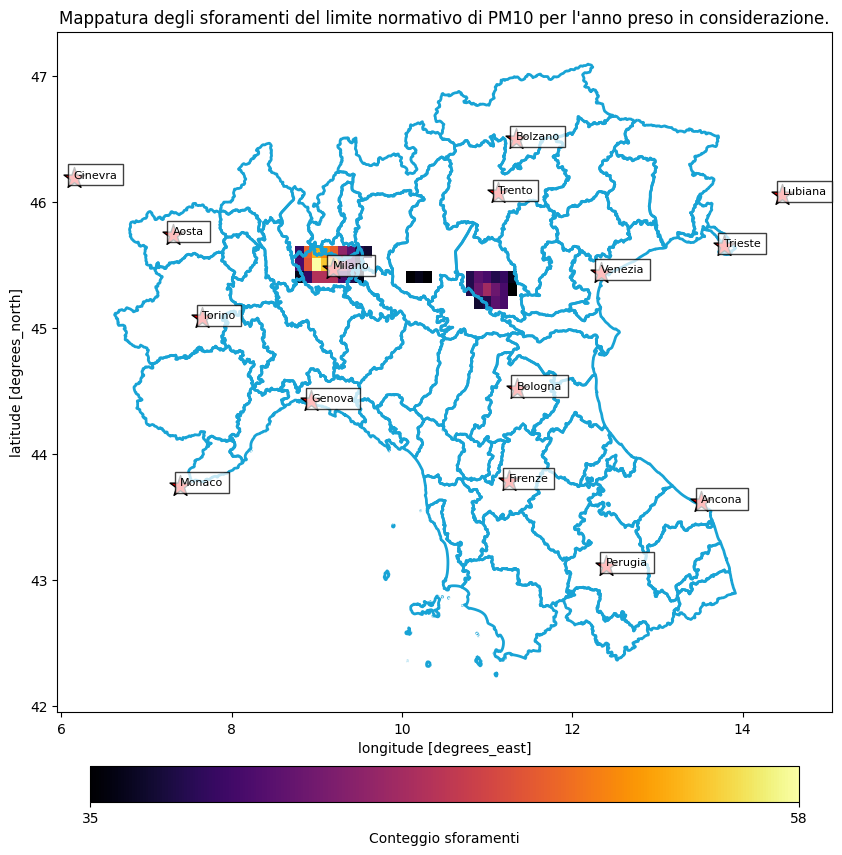

In [23]:
year_data_limit = year_data.where(year_data >= 35)

fig4, ax4 = plt.subplots(figsize=(10, 10))
target_zones.plot(
    ax=ax4,
    facecolor="none", 
    edgecolor="#18A3D5",
    linewidth=2.0
)
year_data_img_limit = year_data_limit.to_array().squeeze().plot.imshow(
    ax=ax4,
    cmap='inferno',
    vmin=law_limit,
    vmax=y_max,
    add_colorbar=False,
)
cbar_ax4 = plt.colorbar(
    year_data_img_limit, 
    ax=ax4,
    orientation='horizontal',
    fraction=0.046, 
    pad=0.07,
)
cbar_ax4.set_label('Conteggio sforamenti')
cbar_ax4.set_ticks([law_limit, y_max])
cbar_ax4.set_ticklabels([str(law_limit), str(y_max)])
for _index, _row in main_city.iterrows():
    coordinates = _row.geometry.xy
    ax4.scatter(
        *coordinates,
        s=250,
        marker="*",
        facecolor='red',
        edgecolor='black'
    )
    plt.text(
        x=coordinates[0][0],
        y=coordinates[1][0],
        s=_row.citta,
        fontdict=dict(color='black', size=8),
        bbox=dict(facecolor='white', alpha=0.75)
    )
plt.title("Mappatura degli sforamenti del limite normativo di PM10 per l'anno preso in considerazione.")
plt.show()

# Analisi su tutti i file

Ora che ho familiarizzato con il dato del singolo anno procedo ad analizzare tutto in una unica volta.

In [14]:
%%time

complete_dataset = []

for nc_file in nc_files:
    dataset = xr.open_mfdataset(
        paths=nc_file,
        engine="netcdf4",
        decode_coords="all",
        parallel=True,
        chunks={'time': 24},
    )
    complete_dataset.append(dataset)

full_dataset = xr.concat(complete_dataset, dim="time")
full_dataset = full_dataset.sortby('time')

full_dataset

CPU times: user 214 ms, sys: 9.71 ms, total: 224 ms
Wall time: 223 ms


<xarray.Dataset> Size: 20GB
Dimensions:                  (lon: 331, lat: 151, time: 98136)
Coordinates:
  * lon                      (lon) float64 3kB 6.0 6.0 6.05 ... 14.95 14.95 15.0
  * lat                      (lat) float64 1kB 42.0 42.05 42.05 ... 46.95 47.0
  * time                     (time) datetime64[ns] 785kB 2013-01-01 ... 2024-...
    level                    float32 4B 0.0
    spatial_ref              int64 8B 0
Data variables:
    particulate_matter_10um  (time, lat, lon) float32 20GB dask.array<chunksize=(24, 151, 331), meta=np.ndarray>
Attributes:
    title:        PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210101-20210131+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of PM10 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)
    pollutant:    particulate_matter_10um
    sea_level:    0

Da notare che l'intero dataset pesa 20GB!

Procedo con il calcolo della media giornaliera e la sostituzione dei valori di sforamento con 1.

In [15]:
%%time

full_dataset_daily_data = full_dataset.resample(time='D').mean('time')  

full_dataset_daily_data

CPU times: user 8.46 s, sys: 78.9 ms, total: 8.54 s
Wall time: 8.46 s


<xarray.Dataset> Size: 818MB
Dimensions:                  (lon: 331, lat: 151, time: 4089)
Coordinates:
  * lon                      (lon) float64 3kB 6.0 6.0 6.05 ... 14.95 14.95 15.0
  * lat                      (lat) float64 1kB 42.0 42.05 42.05 ... 46.95 47.0
    level                    float32 4B 0.0
    spatial_ref              int64 8B 0
  * time                     (time) datetime64[ns] 33kB 2013-01-01 ... 2024-0...
Data variables:
    particulate_matter_10um  (time, lat, lon) float32 817MB dask.array<chunksize=(1, 151, 331), meta=np.ndarray>
Attributes:
    title:        PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210101-20210131+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of PM10 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)
    pollutant:    particulate_matter_10um
    sea_level:    0

In [16]:
%%time

full_dataset_daily_data_target = full_dataset_daily_data.copy()
full_dataset_daily_data_target['particulate_matter_10um'] = xr.where(full_dataset_daily_data_target['particulate_matter_10um'] > 50, 1, 0)

full_dataset_daily_data_target

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12 ms


<xarray.Dataset> Size: 2GB
Dimensions:                  (lon: 331, lat: 151, time: 4089)
Coordinates:
  * lon                      (lon) float64 3kB 6.0 6.0 6.05 ... 14.95 14.95 15.0
  * lat                      (lat) float64 1kB 42.0 42.05 42.05 ... 46.95 47.0
    level                    float32 4B 0.0
    spatial_ref              int64 8B 0
  * time                     (time) datetime64[ns] 33kB 2013-01-01 ... 2024-0...
Data variables:
    particulate_matter_10um  (time, lat, lon) int64 2GB dask.array<chunksize=(1, 151, 331), meta=np.ndarray>
Attributes:
    title:        PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210101-20210131+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of PM10 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)
    pollutant:    particulate_matter_10um
    sea_level:    0

A questo punto posso conteggiare gli sforamenti per tutto il dataset

In [17]:
full_dataset_year_data = full_dataset_daily_data_target.resample(time='YE').sum('time')  
full_dataset_year_data = full_dataset_year_data.where(full_dataset_year_data >= 35)
full_dataset_year_data

<xarray.Dataset> Size: 5MB
Dimensions:                  (time: 12, lat: 151, lon: 331)
Coordinates:
  * lon                      (lon) float64 3kB 6.0 6.0 6.05 ... 14.95 14.95 15.0
  * lat                      (lat) float64 1kB 42.0 42.05 42.05 ... 46.95 47.0
    level                    float32 4B 0.0
    spatial_ref              int64 8B 0
  * time                     (time) datetime64[ns] 96B 2013-12-31 ... 2024-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) float64 5MB dask.array<chunksize=(1, 151, 331), meta=np.ndarray>
Attributes:
    title:        PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210101-20210131+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of PM10 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)
    pollutant:    particulate_matter_10um
    sea_level:    0

Il dataset a questo punto si è ridotto tantissimo in peso.

In [21]:
full_max = int(full_dataset_year_data.max().to_array().values[0])
full_max
print(f"Nell'anno preso in considerazione i valori di PM10 limite previsti dalla normativa sono stati sforati per un massimo di {full_max} volte")

Nell'anno preso in considerazione i valori di PM10 limite previsti dalla normativa sono stati sforati per un massimo di 74 volte


CPU times: user 20.2 s, sys: 2.95 s, total: 23.2 s
Wall time: 18.3 s


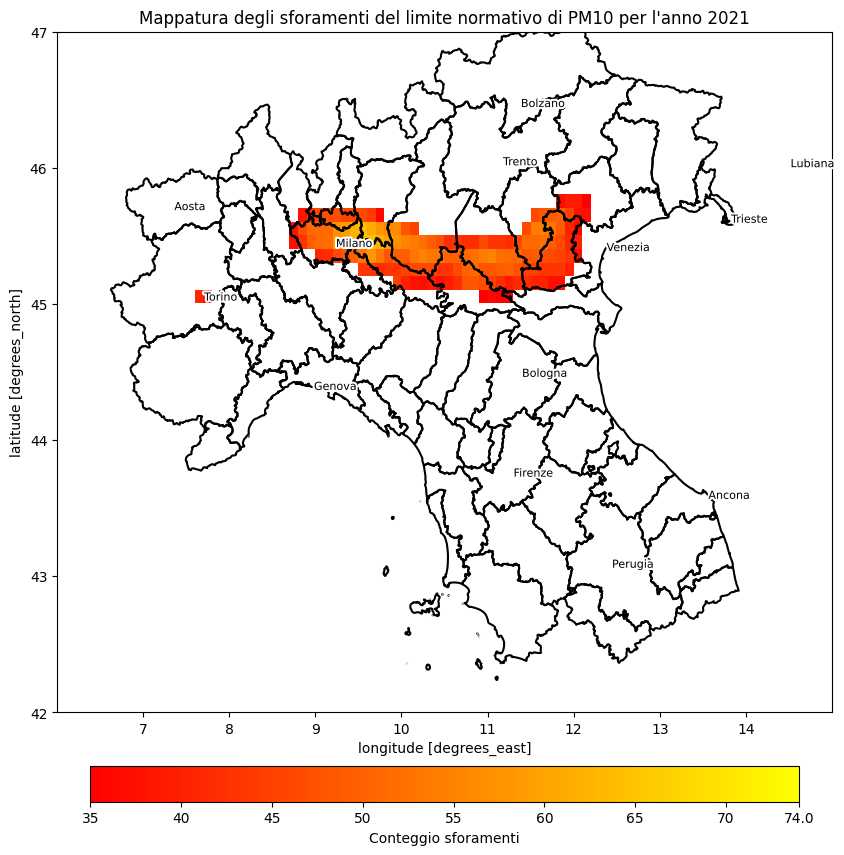

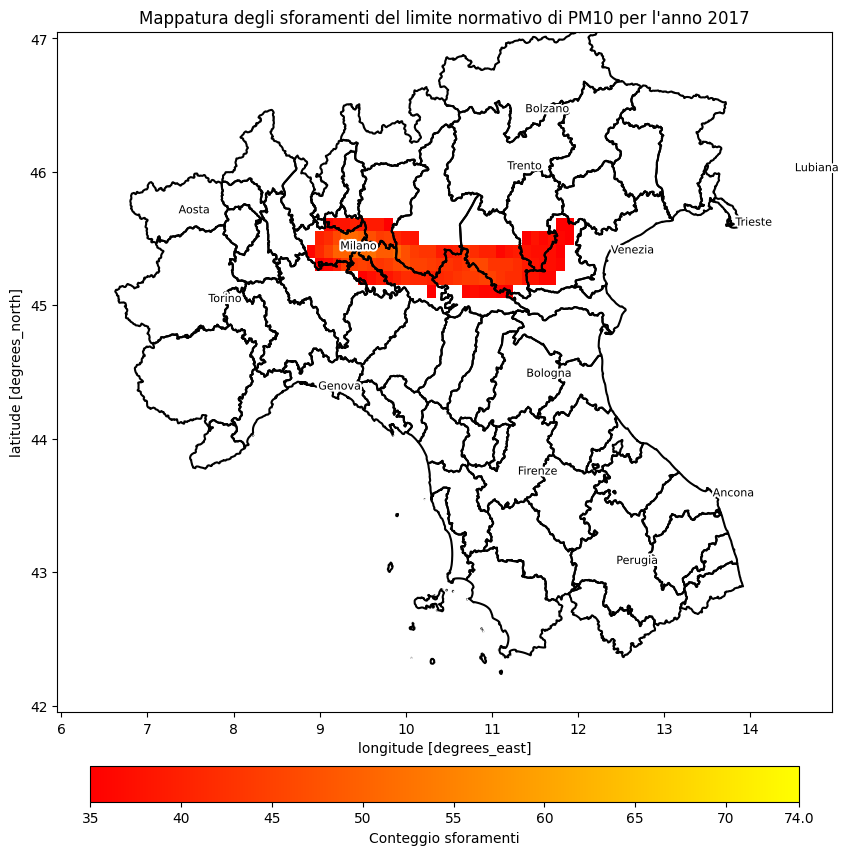

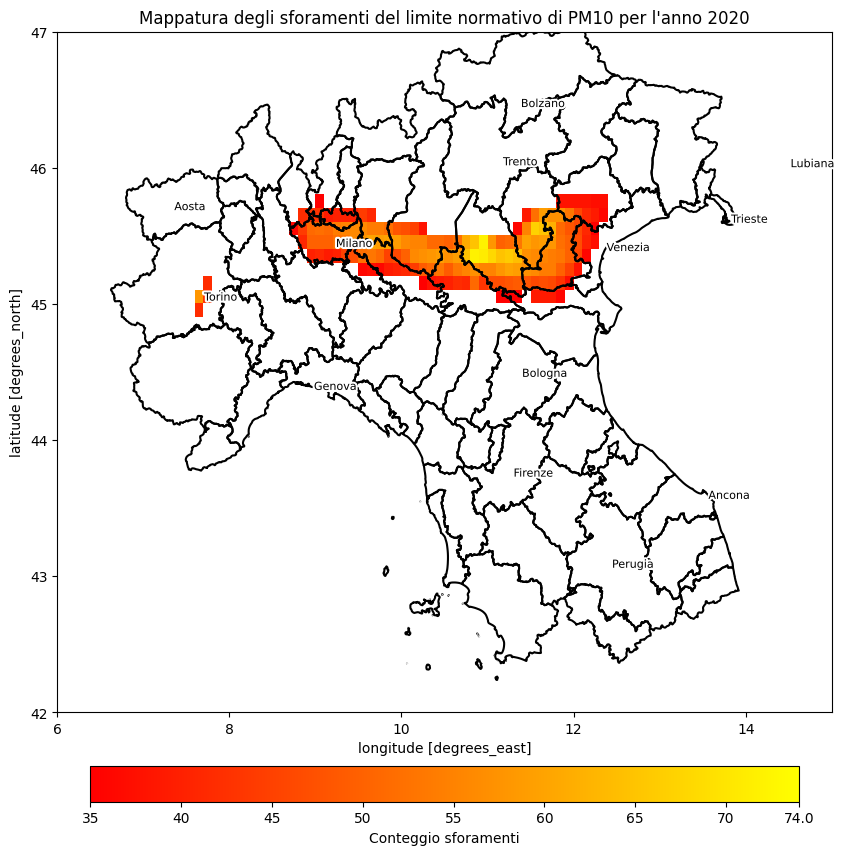

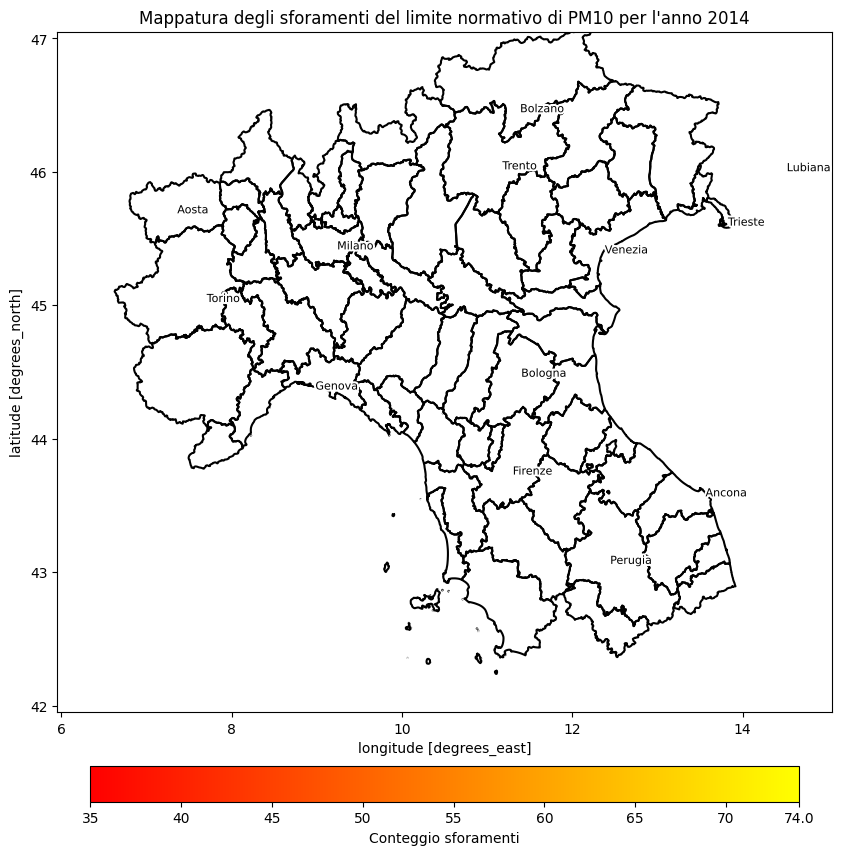

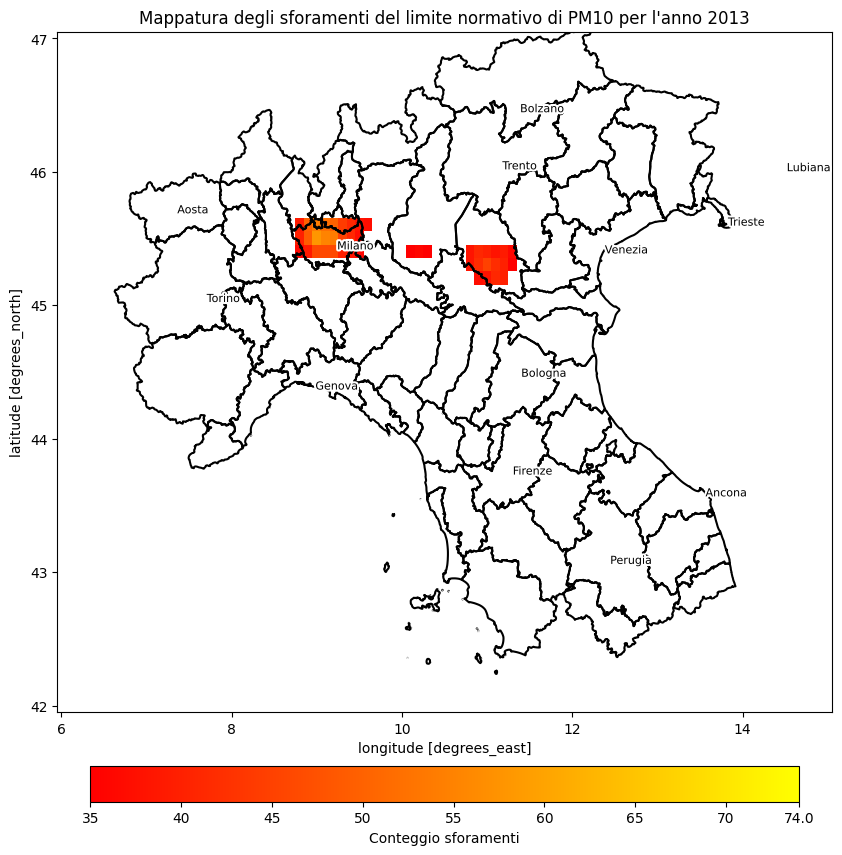

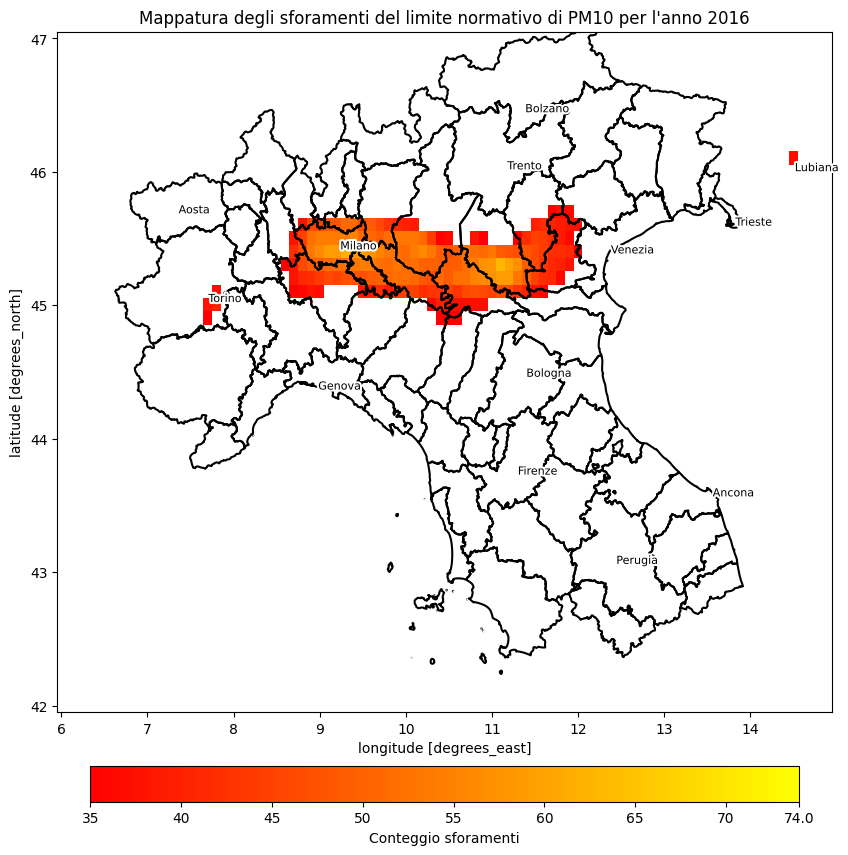

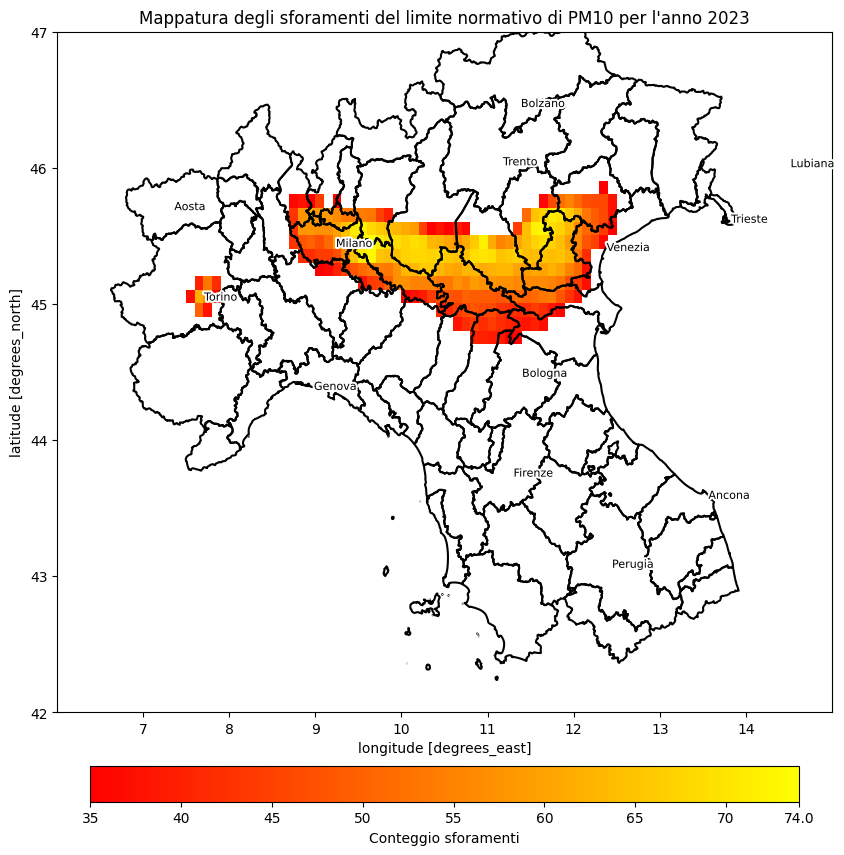

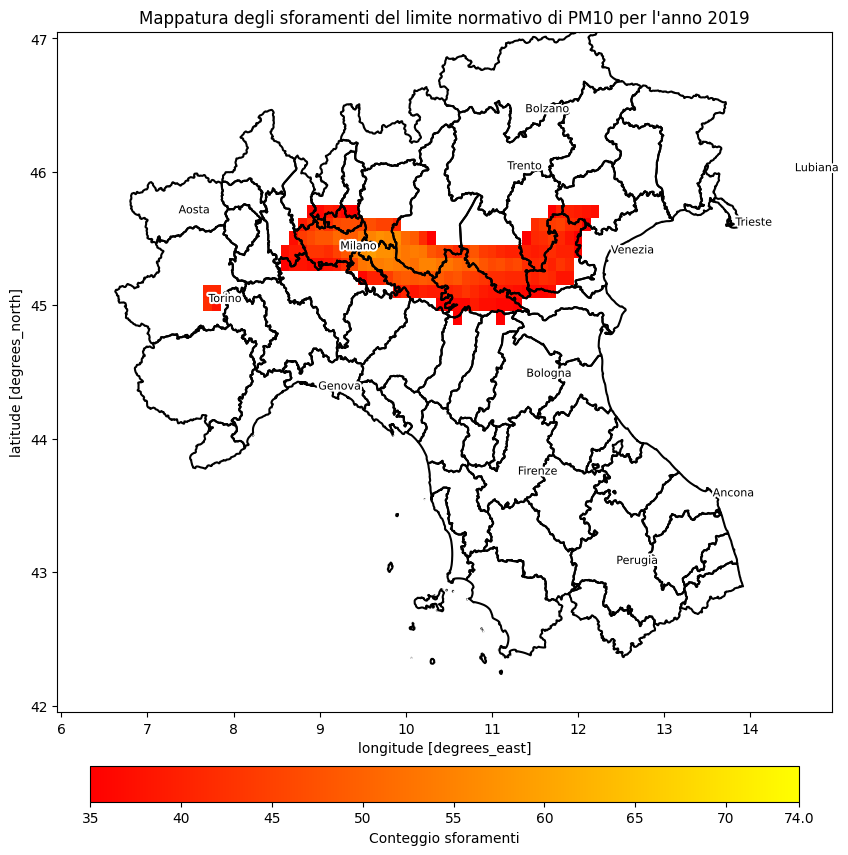

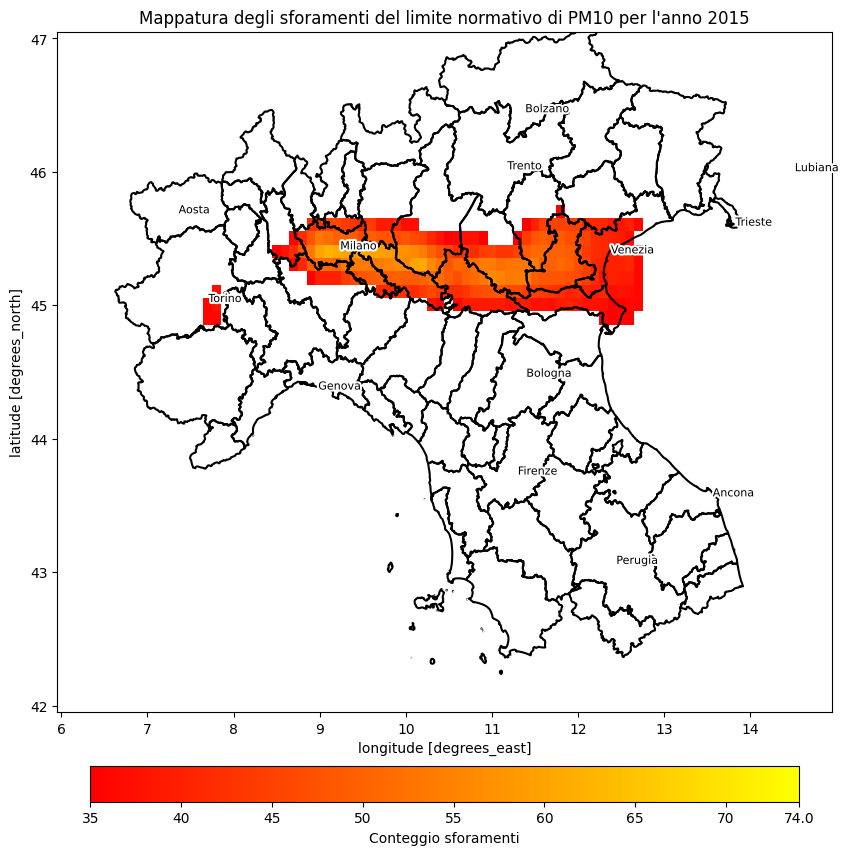

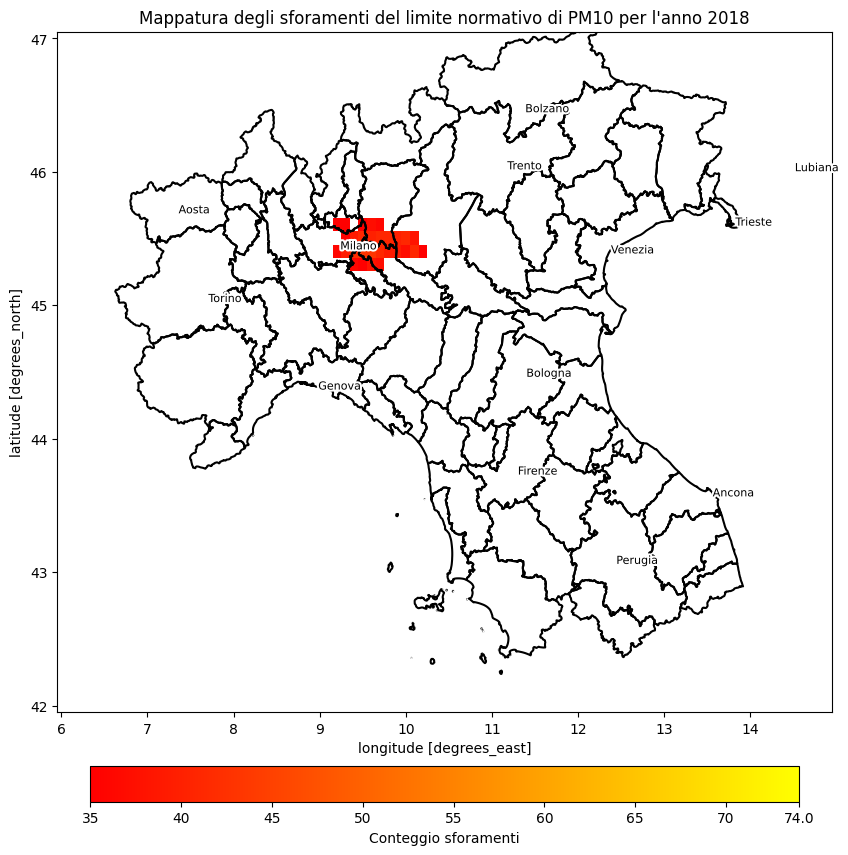

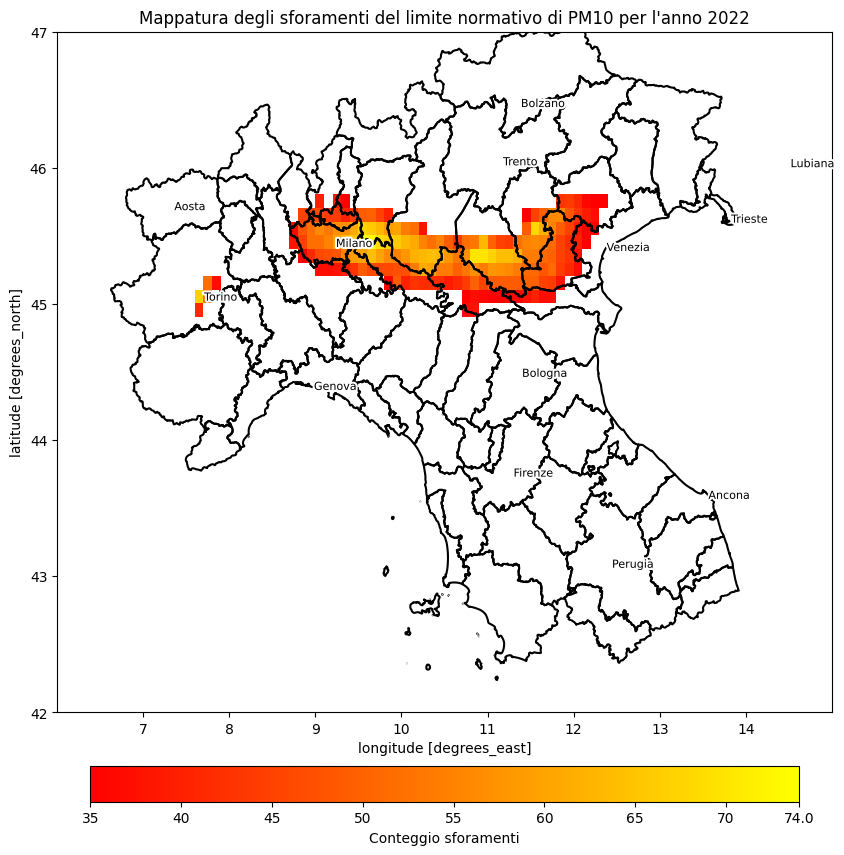

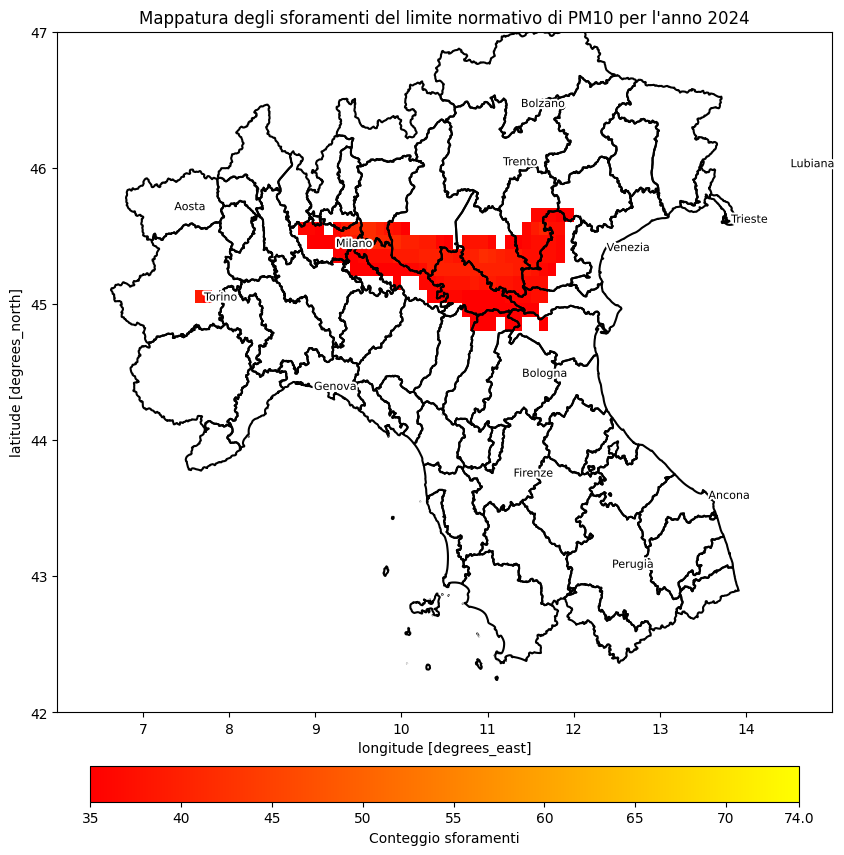

In [19]:
%%time


dataset_list = []
variable = 'particulate_matter_10um'
target_shape = (50, 90)
img_folder = Path.cwd().joinpath('img')
final_main_city = main_city[~main_city['citta'].isin(['Ginevra', 'Monaco'])]
x_offset = 0.05
y_offset = -0.05

for nc_file in nc_files:
    dataset = xr.open_mfdataset(
        paths=nc_file,
        engine="netcdf4",
        decode_coords="all",
        parallel=True,
        chunks={'time': 24},
    )
    dataset = dataset.sortby('time')
    
    daily_mean = dataset.resample(time='D').mean('time')  

    anomaly = daily_mean.copy()
    anomaly[variable] = xr.where(daily_mean[variable] >= 50, 1, 0)
    
    out_layer = anomaly.resample(time='YE').sum('time')  
    out_layer = out_layer.where(out_layer >= 35)
    year = str(out_layer['time'].values[0])[:4]

    fig5, ax5 = plt.subplots(figsize=(10, 10))
    target_zones.plot(
        ax=ax5,
        facecolor="none", 
        edgecolor="black",
        linewidth=1.5
    )
    year_data_img_limit = out_layer.to_array().squeeze().plot.imshow(
        ax=ax5,
        cmap='autumn',
        vmin=law_limit,
        vmax=full_max,
        add_colorbar=False,
    )
    cbar_ax5 = plt.colorbar(
        year_data_img_limit, 
        ax=ax5,
        orientation='horizontal',
        fraction=0.046, 
        pad=0.07,
    )
    cbar_ax5.set_label('Conteggio sforamenti')
    cbar_ax5.set_ticks([law_limit, 40, 45, 50, 55, 60, 65, 70,  full_max])
    cbar_ax5.set_ticklabels([str(law_limit), str(40), str(45), str(50), str(55), str(60), str(65), str(70), str(full_max)])
    for _index, _row in final_main_city.iterrows():
        coordinates = _row.geometry.xy
        label = plt.text(
            x=coordinates[0][0] + x_offset,
            y=coordinates[1][0] + y_offset,
            s=_row.citta,
            fontdict=dict(color='black', size=8),
            path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]
        )
        label.set_path_effects([patheffects.withStroke(linewidth=3, foreground='white')])
    plt.title(f"Mappatura degli sforamenti del limite normativo di PM10 per l'anno {year}")
    
    # Save chart
    chart_name = f'anno_{year}.jpg'
    plt.savefig(img_folder.joinpath(chart_name))


# Conclusione

A parte il poco tempo che ho avuto in questi mesi, l'analisi è stata davvero molto complessa, le difficoltà non sono mancate. Una cosa che non sono riuscito a risolvere è il problema che espongo di seguito e che mi ha costretto ad usare il ciclo for per creare le immagini finali anzichè usare la funzione di selezione temporale che mette e disposizione xarray.

In [20]:
full_dataset_year_data

<xarray.Dataset> Size: 5MB
Dimensions:                  (time: 12, lat: 151, lon: 331)
Coordinates:
  * lon                      (lon) float64 3kB 6.0 6.0 6.05 ... 14.95 14.95 15.0
  * lat                      (lat) float64 1kB 42.0 42.05 42.05 ... 46.95 47.0
    level                    float32 4B 0.0
    spatial_ref              int64 8B 0
  * time                     (time) datetime64[ns] 96B 2013-12-31 ... 2024-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) float64 5MB dask.array<chunksize=(1, 151, 331), meta=np.ndarray>
Attributes:
    title:        PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210101-20210131+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of PM10 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)
    pollutant:    particulate_matter_10um
    sea_level:    0